In [1]:
import os
import glob
import scipy.ndimage
import sklearn.linear_model
import scipy.ndimage.filters

import numpy as np
import pylab as plt

import lemur_util

from lemur_pca import lemur_PCA
from lemur_soar import LemurSOAR
from lemur_timer import LemurTimer


%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0)

NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000


# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

V = np.eye(9216)# lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

In [2]:
N_REPEAT = 1
N_IMAGES = 200
N_TEST = 15
SPLIT_1 = N_IMAGES - N_TEST
SPLIT_2 = 100 * N_REPEAT

# Shuffle images
p = np.random.permutation(200)# N_IMAGES)

neutral = neutral[p]
smiling = smiling[p]

neutral_training = np.append(neutral[:SPLIT_1], smiling[:SPLIT_1], axis=0)
smiling_training = np.append(smiling[:SPLIT_1], smiling[:SPLIT_1], axis=0)

def fliplr(imgs):
  return imgs.reshape(-1, 96, 96)[:,:,::-1].reshape(-1, 9216)

neutral_training = np.append(neutral_training, fliplr(neutral_training), axis=0)
smiling_training = np.append(smiling_training, fliplr(smiling_training), axis=0)

neutral_test = neutral[SPLIT_1:N_IMAGES]# np.append(neutral[SPLIT_1:], smiling[SPLIT_1:], axis=0)
smiling_test = smiling[SPLIT_1:N_IMAGES]# np.append(smiling[SPLIT_1:], smiling[SPLIT_1:], axis=0)

if N_REPEAT > 1:
  neutral_training = lemur_util.distort(np.repeat(neutral_training, N_REPEAT, axis=0), scale=0.05)
  smiling_training = np.repeat(smiling_training, N_REPEAT, axis=0)
  
neutral_training_pca = neutral_training.dot(V)
smiling_training_pca = smiling_training.dot(V)

neutral_test_pca = neutral_test.dot(V)
smiling_test_pca = smiling_test.dot(V)

In [47]:
some_woman = scipy.ndimage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy = scipy.ndimage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
obama = scipy.ndimage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face = scipy.ndimage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255
panther_face = scipy.ndimage.imread('../panther.jpeg', flatten=True).reshape(1, 9216) / 255

In [9]:
std = np.std(smiling_training - neutral_training, axis=0)

std_selection = np.arange(9216)[std>.075]
rect_selection = np.arange(9216).reshape(96, 96)[45:85,25:75].flatten()

all_indices = range(9216)
indices_selected = set(std_selection).intersection(rect_selection)
indices_unselected = [i  for i in all_indices if i not in indices_selected]
indices_selected = list(indices_selected)

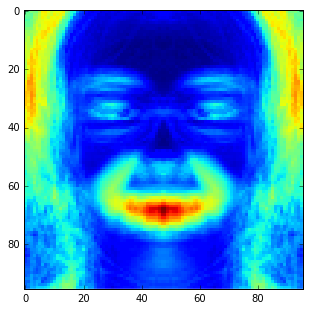

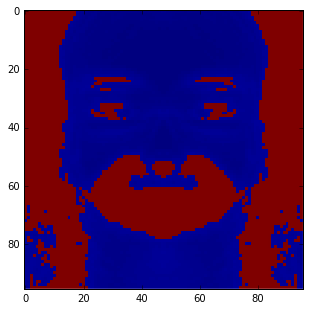

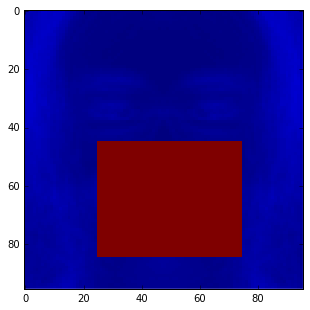

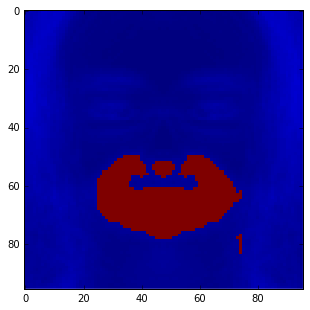

In [10]:

A = std.copy()
A[std_selection] = 2
B = std.copy()
B[rect_selection] = 2
C = std.copy()
C[indices_selected] = 2

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(std.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(A.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(B.reshape(96,96), interpolation='none')
plt.show()
plt.imshow(C.reshape(96,96), interpolation='none')
plt.show()
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [ ]:
std = np.std(smiling_test - neutral_test, axis=0)
M = np.ones(9216)
M[indices_selected] = 0

In [ ]:
rr = sklearn.linear_model.Ridge().fit(neutral_training, smiling_training).predict(neutral_test)
lemur_util.plot_many(3, neutral_test[-5:], rr[-5:], smiling_test[-5:])
print lemur_util.L2_squared(rr - smiling_test) / rr.shape[0]

In [ ]:
class RidgeRegressionTwist:
  def __init__(self, M, alpha=40):
    self.alpha = alpha
    self.M = M
    
  def fit(self, X, Y):
    self.W = sklearn.linear_model.Ridge(alpha=self.alpha).fit(X, Y - X * self.M )
    return self
  
  def predict(self, X):
    return self.W.predict(X) + X * self.M

In [ ]:
rrt = (RidgeRegressionTwist(M=M, alpha=100)
       .fit(neutral_training, smiling_training)
       .predict(neutral_test))
rrt2 = (RidgeRegressionTwist(M=np.ones(9216))
        .fit(neutral_training, smiling_training)
        .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], rrt[-5:], smiling_test[-5:], rrt2[-5:])
print lemur_util.L2_squared(rrt - smiling_test) / rrt.shape[0],\
      lemur_util.L2_squared(rrt2 - smiling_test) / rrt.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [ ]:
class RBF:
  def __init__(self, M, sigma=40, alpha=1):
    self.sigma = sigma
    self.alpha = alpha
    self.M = M
  def fit(self, X, Y):
    n, d = X.shape
    self.X = X
    self.W = np.linalg.inv(np.eye(n) + self.alpha * self.dmatrix(X, X)).dot(Y - X * self.M)
    return self
  def predict(self, X):
    return self.dmatrix(X, self.X).dot(self.W) + X * self.M
  def dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return np.exp(-.5 * K.T / self.sigma)

In [ ]:
rbf = (RBF(M=M, sigma=800)
       .fit(neutral_training, smiling_training)
       .predict(neutral_test))
rbf2 = (RBF(M=np.ones(9216), sigma=400)
        .fit(neutral_training, smiling_training)
        .predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[-5:], rbf[-5:], smiling_test[-5:], rbf2[-5:])
print lemur_util.L2_squared(rbf - smiling_test) / rbf.shape[0],\
      lemur_util.L2_squared(rbf2 - smiling_test) / rbf.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [20]:
class SOAR:
  def __init__(self, kernel, alpha=1, batch_size=80, predict_epochs=300, predict_tol=1e-7):
    self.kernel = kernel
    self.alpha = alpha
    self.batch_size = batch_size
    self.predict_epochs = predict_epochs
    self.predict_tol = predict_tol

  def fit(self, neutral, smiling):
    self.n, self.d = smiling.shape
    
    self.neutral = neutral
    self.smiling = smiling

    self.fit_epochs = (self.n + self.batch_size - 1) / self.batch_size
    
    self.a = np.zeros((self.n, self.d))
    for i in range(self.fit_epochs):
      fr = i * self.batch_size
      to = (i + 1) * self.batch_size
      neutral_idxs = neutral[fr:to]
      smiling_idxs = smiling[fr:to]
      I_n = self.alpha * np.eye(neutral_idxs.shape[0])
      self.kernel.set_x(neutral_idxs, neutral_idxs)   # (n, n)
      self.kernel.set_y(smiling_idxs, smiling_idxs)   # (n, n)
      for j in range(self.d):
        if j % 1000== 0:
          print j
        self.a[fr:to,j] = (np.linalg.inv(self.kernel(j) + I_n)
                           .dot(smiling_idxs[:,j]))
    self.a = self.a.T
        
    return self

  def predict(self, X, Y0=None):
    Y1 = X if Y0 is None else Y0
    self.kernel.set_x(X, self.neutral)
    for _ in range(self.predict_epochs):
      self.kernel.set_y(Y1, self.smiling)
      Y2 = np.zeros(Y1.shape)
      for j in range(self.d):
        Y2[:,j] = self.kernel(j).dot(self.a[j])
      d = lemur_util.L2(Y2 - Y1)
      if d < self.predict_tol:
        break
      Y1 = Y2
    return Y1
  
  def score(self, X, Y):
    return lemur_util.L2_squared(self.predict(X) - Y) / X.shape[0]


In [37]:
class SelectionAware:
  def __init__(self, selection=set(), alpha=.98):
    self.alpha = alpha
    self.selection = selection
  def set_x(self, X1, X2):
    self.X = (X1.dot(X2.T) + 1) / 50
    self.X1 = X1.T
    self.X2 = X2.T
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T) + 1
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    r = k / 96
    c = k % 96
    ks = []
    if r > 0: ks.append(k - 96)
    if c > 0: ks.append(k - 1)
    if r < 95: ks.append(k + 96)
    if c < 95: ks.append(k + 1)
      
    Ky = self.Y1[ks].T.dot(self.Y2[ks]) + 1
    ks += [k]
    Kx = self.X1[ks].T.dot(self.X2[ks]) + 1
    
    K = Kx * Ky
    
    if k in self.selection:
      return (1 - self.alpha) * Kx * Ky + self.alpha * self.X
    return (1 - self.alpha) * Kx * Ky + self.alpha * Kx
    

In [38]:
with LemurTimer("stuff"):
  print neutral_training.shape
  print SOAR(SelectionAware(), batch_size=740).fit(neutral_training, smiling_training).a.shape

Started stuff
(740, 9216)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(9216, 740)
Finished stuff 2m 14s


Started Training 1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
(9216, 740) 740 1
Finished Training 1 2m 35s
Started Training 2
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Finished Training 2 2m 34s


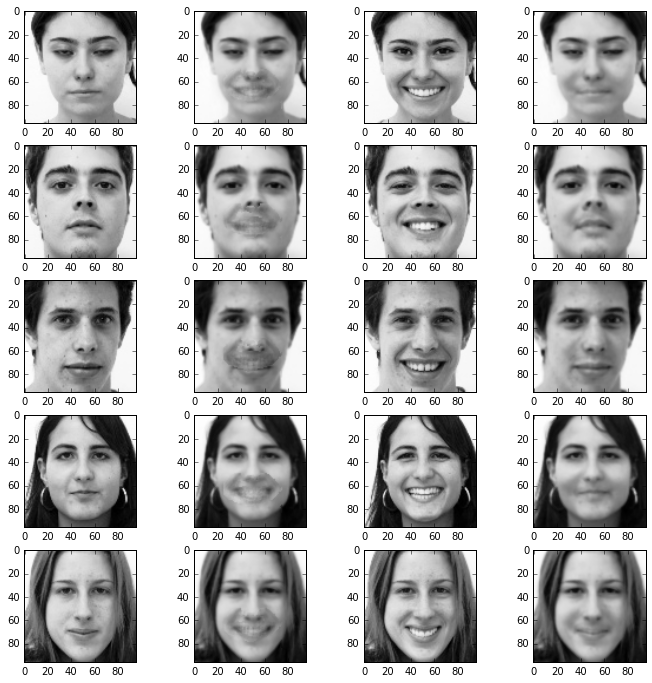

104.513447363 110.275520974


In [39]:
with LemurTimer("Training 1"):
  sa = (SOAR(SelectionAware(selection=set(indices_selected)), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  print sa.a.shape, sa.batch_size, sa.fit_epochs
  sap = (sa.predict(neutral_test))

with LemurTimer("Training 2"):
  sa2 = (SOAR(SelectionAware(), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  sap2 = (sa2.predict(neutral_test))

plt.rcParams['figure.figsize'] = (10.0 / 3 * 3.5, 10.0 / 3 * 3.5)
lemur_util.plot_many(4, neutral_test[:5], sap[:5], smiling_test[:5], sap2[:5])
print lemur_util.L2_squared(sap - smiling_test) / sap.shape[0],\
      lemur_util.L2_squared(sap2 - smiling_test) / sap2.shape[0]
plt.rcParams['figure.figsize'] = (30.0, 30.0)